In [4]:
from __future__ import division
import AudioLoad
import AudioFeatures
import AudioActDet
import AudioSegmentation
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time
import pandas as pd
%matplotlib inline

# Load Sound Track

In [2]:
reload(AudioLoad)

<module 'AudioLoad' from 'AudioLoad.pyc'>

In [43]:
AudioClass = AudioLoad.AudioLoad(Anal_Date = 'Apr-28-2017', Anal_Sample_Time=['1830Z'])

Analyzed File Type and Date: KJFK-Twr-Apr-28-2017
Duration of the sample audio: 1904.01
Sampling rate of the sample audio: 22050


In [44]:
AudioClass.Visualizer(tmin = 0, tmax = 200)

OverflowError: Allocated too many blocks

# Feature Extraction

In [45]:
reload(AudioFeatures)

<module 'AudioFeatures' from 'AudioFeatures.pyc'>

In [46]:
FeatureClass = AudioFeatures.AudioFeatures(AudioLoad = AudioClass,
                                           nperseg = 512,
                                           overlap_rate = 8, 
                                           nfft = 1024, 
                                           fbank_hfreq = None,
                                           pre_emphasis = True)

In [47]:
features = FeatureClass.FeatureExtraction(highest_order = 2, 
                                          num_cep = 12, 
                                          lifting = True, 
                                          lifting_coef = 22, 
                                          mean_normalization = True, 
                                          nshift = 2)

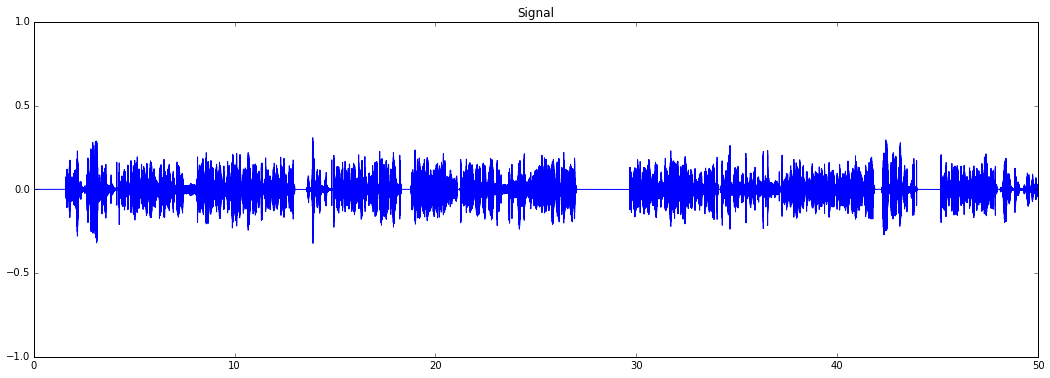

In [48]:
FeatureClass.Visualizer(item = 'signal', tmin = 0, tmax = 50)

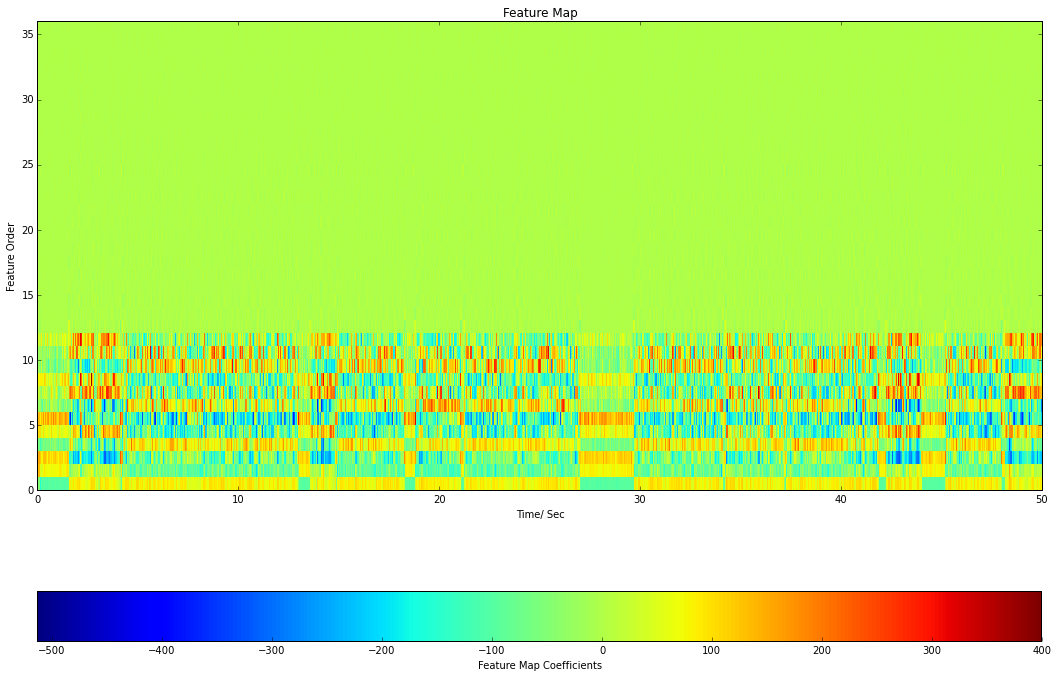

In [49]:
FeatureClass.Visualizer(item = 'features', tmin = 0, tmax = 50)

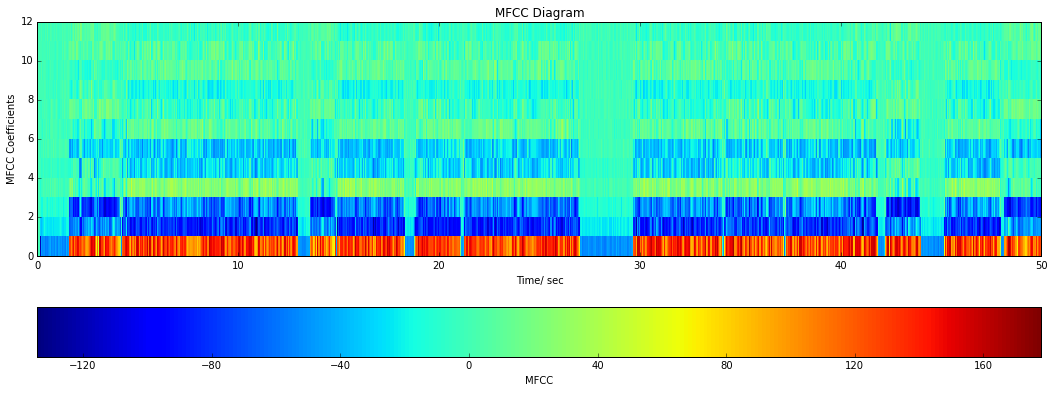

In [50]:
FeatureClass.Visualizer(item = 'mfcc', tmin = 0, tmax = 50)

AudioFeatures.py:192: RuntimeWarning: divide by zero encountered in log10
  im = plt.imshow(np.flipud(10 * np.log10(self.Pxx[:, np.where((self.time_ins >= tmin) & (self.time_ins <= tmax))[0]])),


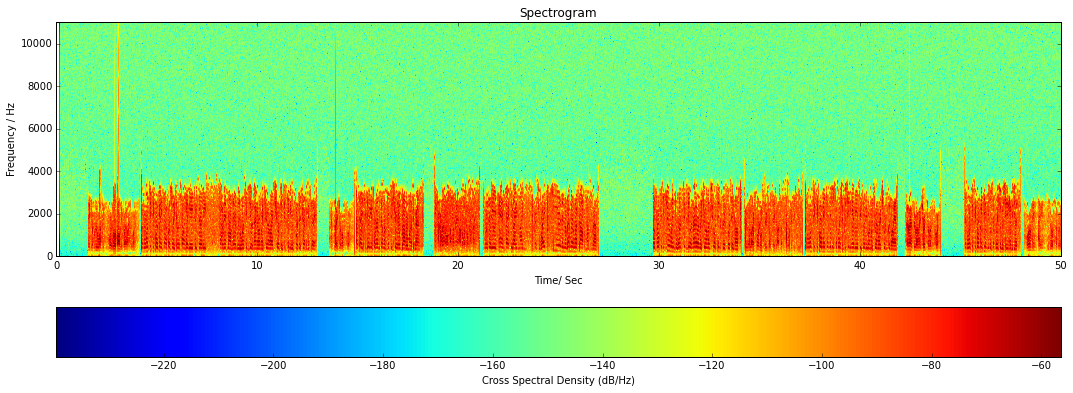

In [51]:
FeatureClass.Visualizer(item = 'spectrogram', tmin = 0, tmax = 50)

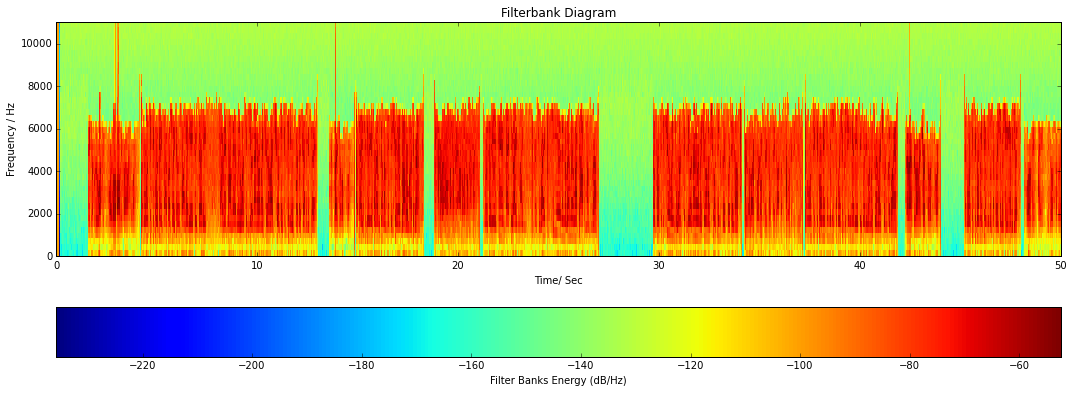

In [52]:
FeatureClass.Visualizer(item = 'filterbank', tmin = 0, tmax = 50)

# VAD

In [53]:
reload(AudioActDet)

<module 'AudioActDet' from 'AudioActDet.pyc'>

In [54]:
VADClass = AudioActDet.AudioActDet(FeatureClass)

In [55]:
sil_seg, silence_seg_2d, idx_act = VADClass.detect_silence(power_threshold = 0,
                                             silence_sec = 0.5, 
                                             mvg_point = 5)

# Audio Segmentation

In [56]:
reload(AudioSegmentation)

<module 'AudioSegmentation' from 'AudioSegmentation.pyc'>

In [57]:
SegClass = AudioSegmentation.AudioSegmentation(features[:, idx_act],
                                               VAD_removal = True)

In [58]:
st = time.time()
segments = SegClass.Segmentation(min_wind = 100,
                                     inc_wind = 20,
                                     max_wind = 300,
                                     mov_frame = 5,
                                     mixture = False,
                                     Lambda = 0.9)
SegIdx2d = SegClass.getResult(AudioActDet = VADClass, minDuration_sec = 0.2)
print(time.time() - st)

94.1100001335


In [65]:
gt = pd.read_csv(os.getcwd() + "/GTResults201704281830.csv")
FAR, MDR, PRC, RCL, F, missed_id = SegClass.evalResult(gt)
print(FAR)
print(MDR)
print(PRC)
print(RCL)
print(F)

0.367483296214
0.133802816901
0.598540145985
0.866197183099
0.707913669065


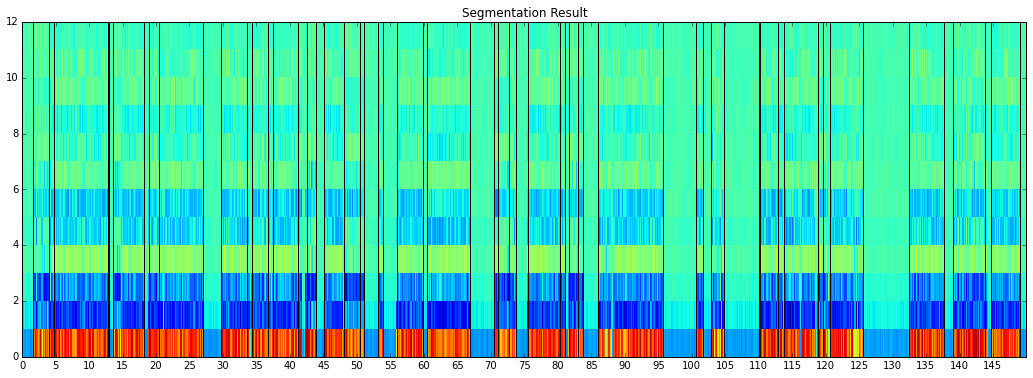

In [63]:
segTime, deadTime = SegClass.Visualizer(tmin = 0, 
                                        tmax = 150, 
                                        AudioFeatures = FeatureClass, 
                                        AudioActDet = VADClass, 
                                        xticks_gap = 5, 
                                        final = True)

In [75]:
pickle.dump(SegClass, open(os.getcwd() + '/AudioDiarization/SegClass.pkl', 'wb'), protocol=2)
pickle.dump(VADClass, open(os.getcwd() + '/AudioDiarization/VADClass.pkl', 'wb'), protocol=2)
pickle.dump(FeatureClass, open(os.getcwd() + '/AudioDiarization/FeatureClass.pkl', 'wb'), protocol=2)
pickle.dump(AudioClass, open(os.getcwd() + '/AudioDiarization/AudioClass.pkl', 'wb'), protocol=2)

# Analize from the previous run

In [5]:
SegClass = pickle.load(open(os.getcwd() + '/AudioDiarization/SegClass.pkl', 'rb'))
VADClass = pickle.load(open(os.getcwd() + '/AudioDiarization/VADClass.pkl', 'rb'))
FeatureClass = pickle.load(open(os.getcwd() + '/AudioDiarization/FeatureClass.pkl', 'rb'))
AudioClass = pickle.load(open(os.getcwd() + '/AudioDiarization/AudioClass.pkl', 'rb'))

In [17]:
# Sweep Lambda

FARs = []
MDRs = []
PRCs = []
RCLs = []
Fs = []
missed_ids = []
time_elaps = []
gt = pd.read_csv(os.getcwd() + "/GTResults.csv")
for lamb in np.arange(0.05, 2, 0.05):
    print("Start lambda = %f"%lamb)
    st = time.time()
    segments = SegClass.Segmentation(min_wind = 100,
                                     inc_wind = 20,
                                     max_wind = 300,
                                     mov_frame = 5,
                                     mixture = False,
                                     Lambda = lamb)
    SegIdx2d = SegClass.getResult(AudioActDet = VADClass, minDuration_sec = 0.2)
    FAR, MDR, PRC, RCL, F, missed_id = SegClass.evalResult(gt)
    if FAR <= 0.35 and MDR <= 0.25:
        print("YES! lambda = %.2f"%lamb)
    FARs.append(FAR)
    MDRs.append(MDR)
    PRCs.append(PRC)
    RCLs.append(RCL)
    Fs.append(F)
    missed_ids.append(missed_id)
    time_elaps.append(time.time() - st)

Start lambda = 0.050000
Start lambda = 0.100000
Start lambda = 0.150000
Start lambda = 0.200000
Start lambda = 0.250000
Start lambda = 0.300000
Start lambda = 0.350000
Start lambda = 0.400000
Start lambda = 0.450000
Start lambda = 0.500000
Start lambda = 0.550000
Start lambda = 0.600000
Start lambda = 0.650000
Start lambda = 0.700000
Start lambda = 0.750000
Start lambda = 0.800000
Start lambda = 0.850000
Start lambda = 0.900000
Start lambda = 0.950000
YES! lambda = 0.95
Start lambda = 1.000000
Start lambda = 1.050000
Start lambda = 1.100000
Start lambda = 1.150000
Start lambda = 1.200000
Start lambda = 1.250000
Start lambda = 1.300000
Start lambda = 1.350000
Start lambda = 1.400000
Start lambda = 1.450000
Start lambda = 1.500000
Start lambda = 1.550000
Start lambda = 1.600000
Start lambda = 1.650000
Start lambda = 1.700000
Start lambda = 1.750000
Start lambda = 1.800000
Start lambda = 1.850000
Start lambda = 1.900000
Start lambda = 1.950000


In [70]:
np.array([FARs, MDRs, Fs, time_elaps]).T

array([[  9.43856144e-01,   3.55871886e-03,   1.05960265e-01,
          7.36500001e+00],
       [  9.43856144e-01,   3.55871886e-03,   1.05960265e-01,
          7.64699984e+00],
       [  9.43856144e-01,   3.55871886e-03,   1.05960265e-01,
          7.48200011e+00],
       [  9.43856144e-01,   3.55871886e-03,   1.05960265e-01,
          7.49799991e+00],
       [  9.43856144e-01,   3.55871886e-03,   1.05960265e-01,
          7.58700013e+00],
       [  9.43676087e-01,   0.00000000e+00,   1.06641366e-01,
          7.52399993e+00],
       [  9.35357718e-01,   0.00000000e+00,   1.21434745e-01,
          7.68099999e+00],
       [  9.11356467e-01,   3.55871886e-03,   1.62318841e-01,
          8.38899994e+00],
       [  8.83062838e-01,   3.55871886e-03,   2.08721580e-01,
          8.60899997e+00],
       [  8.58080808e-01,   0.00000000e+00,   2.48562583e-01,
          8.81000018e+00],
       [  8.39336764e-01,   0.00000000e+00,   2.76847291e-01,
          9.12899995e+00],
       [  8.22824716e

In [40]:
st = time.time()
segments = SegClass.Segmentation(min_wind = 100,
                                     inc_wind = 20,
                                     max_wind = 300,
                                     mov_frame = 5,
                                     mixture = False,
                                     Lambda = 0.9)
SegIdx2d = SegClass.getResult(AudioActDet = VADClass, minDuration_sec = 0.2)

gt = pd.read_csv(os.getcwd() + "/GTResults.csv")
FAR, MDR, PRC, RCL, F, missed_id = SegClass.evalResult(gt)
print("False alarm rate: %.2f"%FAR)
print("Miss detection rate: %.2f"%MDR)
print("Precision: %.2f"%PRC)
print("Recall: %.2f"%RCL)
print("F statistics: %.2f"%F)
print(time.time() - st)

False alarm rate: 0.36
Miss detection rate: 0.14
Precision: 0.60
Recall: 0.86
F statistics: 0.71
102.734999895


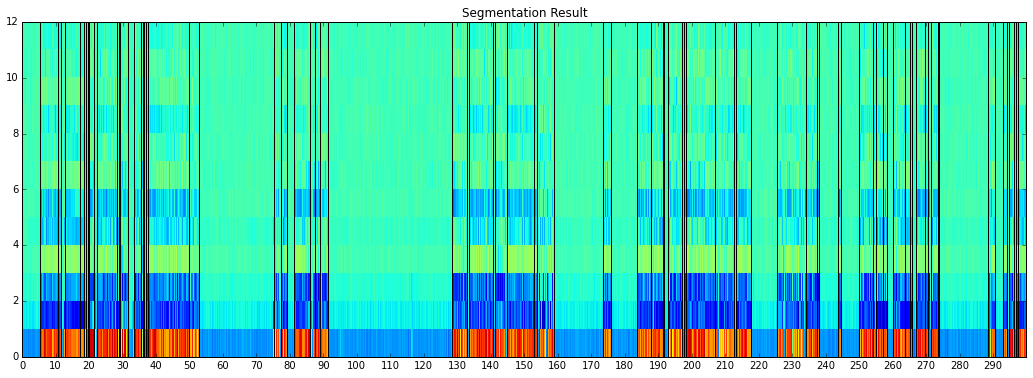

In [42]:
segTime, deadTime = SegClass.Visualizer(tmin = 0, 
                                        tmax = 300, 
                                        AudioFeatures = FeatureClass, 
                                        AudioActDet = VADClass, 
                                        xticks_gap = 10, 
                                        final = True)

# Audio Clustering

In [38]:
import AudioCluster

In [103]:
reload(AudioCluster)

<module 'AudioCluster' from 'AudioCluster.py'>

In [104]:
AudioClusterClass = AudioCluster.AudioCluster(SegIdx2d, features)

In [105]:
pd = AudioClusterClass.getPairwiseDist()

In [106]:
pd

array([[    0.        ,  1860.52172788,  2306.29037558, ...,
         1089.0752625 ,  1184.11854433,  2141.19751646],
       [ 1860.52172788,     0.        ,  3177.55003112, ...,
         1435.54189564,  1653.18773295,  2726.81652171],
       [ 2306.29037558,  3177.55003112,     0.        , ...,
         1168.79190651,  1282.48595478,  1228.17025159],
       ..., 
       [ 1089.0752625 ,  1435.54189564,  1168.79190651, ...,
            0.        ,  1012.87652176,   960.49269746],
       [ 1184.11854433,  1653.18773295,  1282.48595478, ...,
         1012.87652176,     0.        ,  1346.73073694],
       [ 2141.19751646,  2726.81652171,  1228.17025159, ...,
          960.49269746,  1346.73073694,     0.        ]])

In [67]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN

In [101]:
testClusterDB = DBSCAN(eps = 700, min_samples = 2, metric = 'precomputed')
testClusterDB.fit(np.sqrt(pd**2))
testClusterDB.labels_ 

array([-1, -1, -1,  0, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1,  0, -1,  1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,
       -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1,  2, -1, -1,  1,  3, -1, -1,  3, -1, -1,
        1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  3, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  3, -1, -1,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  1,  3, -1, -1, -1, -1, -1, -1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,
        3, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  2, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  3, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  3, -1, -1, -1, -1, -1, -1,  1,
       -1, -1], dtype=int

In [64]:
testCluster = AgglomerativeClustering(n_clusters = 100, affinity = 'precomputed', linkage='average')

In [65]:
testCluster.fit(pd)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=100,
            pooling_func=<function mean at 0x0000000002501128>)

In [66]:
testCluster.labels_

array([ 4,  0,  0,  0,  0,  0,  0, 90, 85,  0,  0,  0,  0,  0,  0,  9,  0,
       55,  0,  0,  0,  0, 77,  0, 81, 52,  0, 84,  8,  0, 17, 59, 94,  0,
        0, 57, 20, 22,  0, 62,  0, 17,  4, 50, 61, 60,  0, 80, 58,  0,  0,
        0, 56,  0,  0,  0,  0, 11, 28, 73, 51, 89,  0,  0,  5,  0, 87,  0,
       72, 79, 22, 86,  3, 76, 92,  0, 69,  0, 71, 10,  0,  0,  0,  0,  8,
        0,  0, 75,  3, 27, 29, 67, 37, 65, 95, 91, 30, 63, 78,  0, 39,  7,
       66,  0,  0, 93,  5,  0,  0, 97,  0, 20, 54,  0,  0, 64,  0, 13,  7,
        0, 31, 83,  0,  0,  0,  0,  0,  0,  0, 41, 98,  0,  2, 35,  0, 32,
        0, 25,  0,  0,  0,  0, 99, 24,  0,  0,  9,  0,  0,  0, 88,  0, 96,
       42,  0,  0, 14,  0,  0,  0, 82, 49,  0,  0, 10, 70, 53, 47,  0, 74,
       11,  0,  0, 38, 40,  0,  0,  0, 45, 68,  6,  1, 26,  0, 24,  0, 36,
        0,  0, 12, 15, 44,  0,  0,  0,  0,  0, 34, 43, 21, 48,  1,  0,  0,
       46, 19,  0,  0,  0,  0,  0,  0,  0, 33,  0, 18,  0,  0,  2,  0, 23,
       16,  0], dtype=int

In [3]:
# SegClass = pickle.load(open(os.getcwd() + '/AudioDiarization/SegClass.pkl', 'rb'))
# VADClass = pickle.load(open(os.getcwd() + '/AudioDiarization/VADClass.pkl', 'rb'))
# FeatureClass = pickle.load(open(os.getcwd() + '/AudioDiarization/FeatureClass.pkl', 'rb'))
# AudioClass = pickle.load(open(os.getcwd() + '/AudioDiarization/AudioClass.pkl', 'rb'))